In [1]:
# import packages
import glob
from pathlib import Path
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import math
from pathos.threading import ThreadPool as Pool
from scipy.optimize import least_squares
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import random

In [3]:
# define your script working directory
work_dir=Path("/mnt/u/LSM root zone/global_sr/")
# work_dir=Path('/tudelft.net/staff-umbrella/LSM root zone/global_sr')

# define your data directory
data_dir=Path(f'{work_dir}/data')

out_dir=Path(f'{work_dir}/output')

### 1. map selected catchments

### 2. plot catchments in budyko

In [5]:
c = pd.read_csv(f'{out_dir}/catchment_characteristics.csv',index_col=0)
c

,p_mean,ep_mean,q_mean,t_mean,ai,si_p,si_ep,phi,tc,ntc,nonveg,area
102101A,26.111414,5.013324,2.451285,3.821485,5.208403,0.052301,0.845662,1,23.077881,64.030838,12.891281,6.484000e+02
ar_0000008,21.514082,4.478494,1.094832,2.804694,4.803865,0.166373,0.279538,3,17.329813,70.978290,11.691898,1.510756e+04
ar_0000001,2.870530,22.567559,1.354127,4.287819,0.127197,0.213515,0.083267,1,19.960333,68.424506,11.615161,8.918319e+05
ar_0000005,23.028048,2.942214,0.864945,3.631584,7.826776,0.095058,0.232785,0,23.192699,64.258747,12.548554,2.021051e+06
ar_0000006,2.883051,22.474773,0.669215,3.527318,0.128279,0.251582,0.108883,0,21.858087,65.052455,13.089458,2.298484e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
zw_0000041,3.142379,18.777279,0.360042,2.897911,0.167350,0.224099,0.108324,0,16.590410,64.299494,19.110096,1.257873e+02
zw_0000065,2.725506,2.116412,0.313023,18.894012,1.287796,0.201911,0.901798,0,13.106703,68.745179,18.148118,3.315826e+03
zw_0000068,3.138246,2.838255,0.464055,19.060713,1.105695,0.827212,0.205115,0,18.563534,65.035161,16.401305,2.223119e+03
zw_0000077,1.735157,2.733249,0.030142,19.664812,0.634833,0.905109,0.218184,1,7.357007,72.066081,20.576912,3.939916e+02


In [15]:
c.p_mean.median()

2.904162255218344

(-0.1, 1.1)

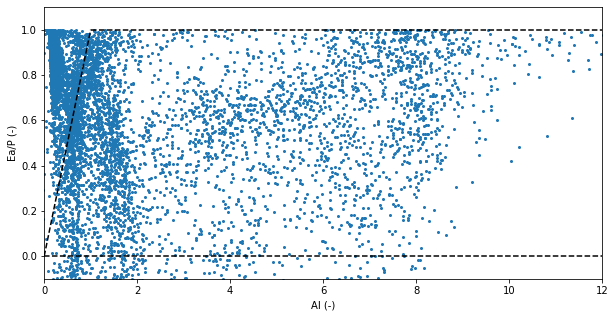

In [18]:
ep = c.t_mean
p = c.ep_mean
q = c.q_mean
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.plot(ep/p, (p-q)/p, 'o', markersize=2)
ax.plot([0,1],[0,1], '--k')
ax.plot([1,12],[1,1], '--k')
ax.plot([0,12],[0,0], '--k')
ax.set_xlabel('AI (-)')
ax.set_ylabel('Ea/P (-)')
ax.set_xlim(0,12)
ax.set_ylim(-0.1,1.1)


### 3. make histograms of catchment characteristics